In [2]:
import numpy as np
import pandas as pd
from cmaes import CMA
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from pathlib import Path
from matplotlib import pyplot as plt

/Users/teppei/.local/share/virtualenvs/SETI-rgkZMqMW/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
expts = [
    'efficientnetb0_100epoch',
    'efficientnetv2s_100epoch',
    'mobilenet100-100epoch',
    'resnet18-10_30epoch',
    'resnet18-18epoch',
    'resnext50-75epoch',
]

basedir = Path('.').resolve()

In [4]:
# read oof

train_df = pd.read_csv(basedir.parent / 'seti-breakthrough-listen' / 'train_labels.csv')

folds = list()
for _expt in expts:
    _df = pd.read_csv(basedir / _expt / 'output' / 'oof_prediction.csv')
    _df = _df.set_index('id')
    train_df[_expt] = train_df.id.map(_df['target'])
    folds.append(_df['fold'].values)
    
assert all(np.all(folds[0] == _fold) for _fold in folds)

train_df['fold'] = folds[0]
train_df.to_csv('./oof_prediction.csv')

In [6]:
# read test

test_df = pd.read_csv(basedir.parent / 'seti-breakthrough-listen' / 'sample_submission.csv')

for _expt in expts:
    _df = pd.read_csv(basedir / _expt / 'output' / 'submission.csv')
    _df = _df.set_index('id')
    test_df[_expt] = test_df.id.map(_df['target'])
test_df.to_csv('./test_prediction.csv')

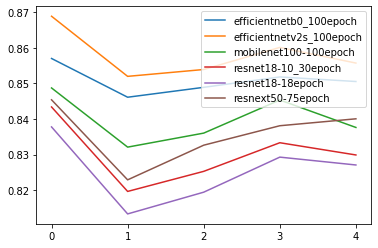

In [70]:
scores = dict()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for _expt in expts:
    y = list()
    for _fold in range(5):
        pred, target = train_df[_fold == train_df.fold][[_expt, 'target']].values.T
        y.append(roc_auc_score(target, pred))
    ax.plot(y, label=_expt)
    scores[_expt] = y
ax.legend()
ax.set_xticks(range(5))

# average
scores['average'] = list()
for _fold in range(5):
    _df = train_df[train_df.fold == _fold]
    target = _df['target'].values
    pred = _df[expts].mean(axis=1).values
    pred = np.clip(pred, 0, 1)
    scores['average'].append(roc_auc_score(target, pred))

In [72]:
scores['efficientnetv2s_100epoch'], scores['average']

([0.8688792438271605,
  0.8519866898148148,
  0.8539111111111112,
  0.8601208333333333,
  0.8557216820987654],
 [0.864617438271605,
  0.8509635030864198,
  0.8521184413580246,
  0.8600412037037036,
  0.8563163580246914])

## average 

In [79]:
pred = test_df[expts].mean(axis=1).values
pred = np.clip(pred, 0, 1)

submission_df = test_df[['id', 'target']].copy()
submission_df['target'] = pred
submission_df.head()

,id,target
0,000bf832cae9ff1,0.067910
1,000c74cc71a1140,0.101294
2,000f5f9851161d3,0.068591
3,000f7499e95aba6,0.115688
4,00133ce6ec257f9,0.080315


In [80]:
submission_df.to_csv('submission.csv', index=False)

## CMA :whole data

In [91]:
def objective(x):
    df = train_df
    pred = x[0] + np.dot(df[expts].values, x[1:])
    pred = np.clip(pred, 0, 1)
    target = df['target'].values
    return roc_auc_score(target, pred)

In [103]:
weights = np.array([0] + (np.ones(len(expts)) / len(expts)).tolist())

optimizer = CMA(mean=weights, sigma=1.3)

best = 0
best_x = None
for generation in range(300):
    solutions = []
    for _ in range(optimizer.population_size):
        x = optimizer.ask()
        value = objective(x=x)
        solutions.append((x, -value))
        if best < value:
            best = value
            best_x = x
            print(f"#{generation} {np.round(value, 5)} {np.round(best_x, 3)}")
    optimizer.tell(solutions)

#0 0.5 [-3.234  0.709 -1.156  0.77   0.957  0.42  -1.275]
#0 0.50389 [-0.118 -0.23   0.015 -1.5   -0.813 -0.379  1.375]
#0 0.67263 [ 0.832 -2.347  3.296 -0.162  1.554  1.618 -0.482]
#0 0.76122 [-0.248 -0.061 -2.347  0.986  0.477  3.585  1.475]
#0 0.83976 [-0.331  0.193  1.247  1.099  1.263  1.435 -0.124]
#2 0.85159 [-0.037  0.096  2.879 -0.078 -0.547  1.324 -0.991]
#8 0.8539 [-0.189  3.287  4.254 -0.369 -2.285  2.161 -0.495]
#10 0.85414 [-0.143  4.876  3.78  -1.865 -1.018  1.153  0.065]
#16 0.85422 [-0.256  6.666  3.568 -0.11  -1.368  0.802  0.728]
#19 0.85455 [-0.112  5.406  1.466 -0.916 -0.405  1.427  0.725]
#21 0.85494 [-0.228  4.337  2.478 -1.201 -0.086  2.005  0.756]
#22 0.85569 [-0.187  3.85   1.293 -0.484  0.198  1.122  0.26 ]
#23 0.85717 [-0.134  4.169  1.897 -0.052 -0.152  0.711  0.917]
#26 0.85745 [-0.039  4.176  2.239  0.285  0.579  0.402 -0.663]
#26 0.85785 [-0.062  3.009  0.934  0.849  0.081  0.572 -0.32 ]
#28 0.85843 [-0.057  2.871  1.806  0.237  0.511  0.675 -0.639]
#29 

In [105]:
# weighted combination
pred = test_df[expts].values
pred = best_x[0] + np.dot(pred, best_x[1:])
pred = np.clip(pred, 0, 1)

submission_df = test_df[['id', 'target']].copy()
submission_df['target'] = pred
submission_df.head()

,id,target
0,000bf832cae9ff1,0.118870
1,000c74cc71a1140,0.143420
2,000f5f9851161d3,0.115490
3,000f7499e95aba6,0.180301
4,00133ce6ec257f9,0.127859


In [106]:
submission_df.to_csv('submission.csv', index=False)

## CMA whole data, sigmoid

In [107]:
def objective(x):
    df = train_df
    pred = x[0] + np.dot(df[expts].values, x[1:])
    pred = 1 / (1 + np.exp(- pred))
    target = df['target'].values
    return roc_auc_score(target, pred)

In [108]:
weights = np.array([0] + (np.ones(len(expts)) / len(expts)).tolist())

optimizer = CMA(mean=weights, sigma=1.3)

best = 0
best_x = None
for generation in range(300):
    solutions = []
    for _ in range(optimizer.population_size):
        x = optimizer.ask()
        value = objective(x=x)
        solutions.append((x, -value))
        if best < value:
            best = value
            best_x = x
            print(f"#{generation} {np.round(value, 5)} {np.round(best_x, 3)}")
    optimizer.tell(solutions)

#0 0.81598 [-0.692  0.031  0.712 -0.165 -1.537  1.266  0.3  ]
#0 0.85736 [-0.518  0.504  2.366  1.15   2.054 -2.338  0.773]
#2 0.85784 [ 0.293  0.684  2.405  0.097  2.801 -1.398  1.793]
#3 0.8606 [-1.769  1.496  2.426  0.012  0.048 -0.106 -0.041]
#4 0.8607 [-1.639  1.312  2.964  0.443 -0.305  0.611  0.132]
#5 0.86078 [ 1.917  2.157  2.779  0.442  0.713 -0.018 -0.504]
#10 0.86085 [-0.705  3.917  6.58   1.341  2.347 -0.928  1.007]
#12 0.86096 [-0.955  5.326  8.129  1.497  2.039 -0.631  1.243]
#13 0.86098 [0.397 5.306 8.89  2.452 0.339 0.603 0.428]
#14 0.861 [ 0.806  7.117 15.208  4.412  1.858 -0.737  0.957]
#16 0.861 [ 3.083 10.463 21.402  2.662  1.621 -0.896  3.255]
#17 0.86104 [ 0.461 12.732 22.443  5.599  3.426 -1.694  0.832]
#20 0.86106 [-2.088 12.108 23.504  4.297  3.147  0.316  0.342]
#27 0.86106 [ 0.901 13.813 23.763  3.443  1.8    0.292 -0.113]
#29 0.86107 [ 1.498 12.098 24.267  3.272  2.653 -0.581  1.679]
#32 0.86108 [-0.792 14.72  25.555  3.889  3.85  -0.702  1.358]
#32 0.86108

In [113]:
sub_lb = pd.read_csv('./submission_pl0.757.csv')
my_sub = pd.read_csv('./submission.csv')
submission_df = sub_lb.merge(my_sub, on='id')
submission_df['target'] = (submission_df['target_x'] + submission_df['target_y']) / 2
submission_df['target'] = np.clip(submission_df['target'], 0, 1)
submission_df = submission_df[['id', 'target']]
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

,id,target
0,000bf832cae9ff1,0.068660
1,000c74cc71a1140,0.094756
2,000f5f9851161d3,0.072107
3,000f7499e95aba6,0.134144
4,00133ce6ec257f9,0.080393
